# LLM from scratch

The goal is to code from scratch (using Pytorch) a Transformer, more precisely a GPT-like model (using a decoder-only architecture). See discussion at the end for what's missing to build a full blown LLM.

Credits and references: 
* I strongly recommend Andrej Karpathy's lectures, videos, and repositories, in particular
https://github.com/karpathy/nn-zero-to-hero
https://github.com/karpathy/makemore
* A fantastic reference which goes in a lot more depth, is Sebastian Raschka's book and codebase:
https://github.com/rasbt/LLMs-from-scratch
Most illustrations below are from the book.

Full notebook: https://github.com/nathanael-fijalkow/LLM_from_scratch

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

What we will do here: train a generative model with political speeches (State of the Union).
The goal is to generate more speeches!

In [3]:
# main model and data hyperparameters
batch_size = 32 # number of sequences processed in parallel
block_size = 16 # maximum context length for predictions
n_token = 512 # number of tokens (used for word level tokenizer)

# the rest of the hyper parameters are defined with the models
n_embed = 64 # size of hidden layer

Note: the hyper parameters were **not** optimised at all! Also, the code runs on CPU, not GPU. It is mostly for educational purposes.

## Part 1: Playing with the dataset

Let's download the dataset.

In [4]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/sotu.txt

--2024-11-19 21:25:59--  https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/sotu.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1279319 (1,2M) [text/plain]
Saving to: ‘sotu.txt.1’

sotu.txt.1          100%[===================>]   1,22M  --.-KB/s    in 0,08s   

2024-11-19 21:26:00 (14,8 MB/s) - ‘sotu.txt.1’ saved [1279319/1279319]



In [5]:
with open('sotu.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = text.lower()
print(text[:1000])

mr. speaker, mr. president, and distinguished members of the house and senate,
honored guests, and fellow citizens: less than 3 weeks ago, i joined you on the
west front of this very building and, looking over the monuments to our proud
past, offered you my hand in filling the next page of american history with a
story of extended prosperity and continued peace. and tonight i'm back to offer
you my plans as well. the hand remains extended; the sleeves are rolled up;
america is waiting; and now we must produce. together, we can build a better
america.

it is comforting to return to this historic chamber. here, 22 years ago, i first
raised my hand to be sworn into public life. so, tonight i feel as if i'm
returning home to friends. and i intend, in the months and years to come, to
give you what friends deserve: frankness, respect, and my best judgment about
ways to improve america's future. in return, i ask for an honest commitment to
our common mission of progress. if we seize the oppor

In [6]:
data_size = len(text)
data_size

1279319

We will start with a basic character-level tokenizer

In [7]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
# encoder: take a string, output a list of integers
encode = lambda s: [stoi[c] for c in s] 
# decoder: take a list of integers, output a string
decode = lambda l: ''.join([itos[i] for i in l]) 

print(itos)

{0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: ',', 11: '-', 12: '.', 13: '/', 14: '0', 15: '1', 16: '2', 17: '3', 18: '4', 19: '5', 20: '6', 21: '7', 22: '8', 23: '9', 24: ':', 25: ';', 26: '?', 27: 'a', 28: 'b', 29: 'c', 30: 'd', 31: 'e', 32: 'f', 33: 'g', 34: 'h', 35: 'i', 36: 'j', 37: 'k', 38: 'l', 39: 'm', 40: 'n', 41: 'o', 42: 'p', 43: 'q', 44: 'r', 45: 's', 46: 't', 47: 'u', 48: 'v', 49: 'w', 50: 'x', 51: 'y', 52: 'z'}


In [8]:
test = "hello world"
test_encoded = encode(test)
test_encoded, decode(test_encoded)

([34, 31, 38, 38, 41, 1, 49, 41, 44, 38, 30], 'hello world')

In [9]:
test_encoded = torch.tensor(test_encoded)
test_tensor = F.one_hot(test_encoded, num_classes=vocab_size).float()
test_tensor, test_tensor.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.

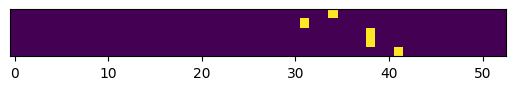

In [10]:
# The first 5 characters code for "hello"
plt.yticks([])
plt.imshow(test_tensor[:5]);

We encode the entire text dataset and store it into a `torch.Tensor`.

In [11]:
data = torch.tensor(encode(text))
print(data.shape)

torch.Size([1279319])


We split up the data into train and validation sets.

In [12]:
n = int(0.9*len(data)) 
# first 90% goes to training
train_data = data[:n]
# the rest goes to validation
val_data = data[n:]

`get_data` produces a random pair of consecutive characters, one-hot encoded.

In [13]:
def get_data(split):
    data = train_data if split == 'train' else val_data
    i = torch.randint(len(data) - 1, (1,))
    x = F.one_hot(data[i], num_classes=vocab_size).float()
    y = F.one_hot(data[i+1], num_classes=vocab_size).float()
    return x,y
        
get_data("train")

(tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

## Part 2: Bigram model

We define our first model, a very basic bigram model: it is a Markov chain, which chooses the next character based only on the current character. It uses cross entropy loss, illustrated below.

`W` is a `(vocab_size,vocab_size)` matrix. We use `nn.Parameter` to tell Pytorch that the entries of `W` are parameters of the model.

To define a model, we typically write two functions:
* `init`, which initialises the model,
* `forward`, which is how the model is run. 

`forward` takes either only an input `x`, or both an input `x` and the expected target `y`. The model returns two tensors: `logits` and `loss`:
* `logits` represents the predictions of the model on input `x`,
* `loss` computes the loss of the model on `x` for predicting `y`.

In [14]:
class Bigram(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.zeros((vocab_size, vocab_size)))

    def forward(self, x, y=None):
        logits = x @ self.W
        
        if y is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, y)

        return logits, loss    

In [15]:
model = Bigram()
print(sum(p.numel() for p in model.parameters()), ' parameters')

2809  parameters


The code below illustrates how cross entropy loss is computed.

We start from a pair `(x,y)`, where `x` is an input and `y` the target output. For the bigram model, `x` and `y` are consecutive characters in our training data.
The output of our model on input `x` will be some tensor `logits`. It assigns to each class (here, a class is a character) a float value. The `logits` are turned into a probabilistic distribution using a softmax (exponentiation and normalisation). For numerical stability we prefer to work with "log probabilities" as summing numbers is easier than multiplying them.

In [16]:
number_classes_test = 5

logits = torch.randn(number_classes_test)
print("The logits: \n", logits)
logits_exped = logits.exp()
print("After exponentiation: \n", logits_exped)
probs = logits_exped / logits_exped.sum()
print("After normalisation: \n", probs)
print("\nThe two steps above are called softmax: \n", F.softmax(logits, 0))

y = torch.randint(number_classes_test, (), dtype=torch.int64)
print("\nLet us consider a target y: ", y.item())

loss = F.cross_entropy(logits, y)
print("The cross entropy loss between logits and y is: ", loss.item())

logprobs = -probs.log()
print("\nThis is the -log probabilities: \n", logprobs)


The logits: 
 tensor([-1.2391,  0.3244,  0.7717, -0.1472,  0.8193])
After exponentiation: 
 tensor([0.2896, 1.3832, 2.1635, 0.8631, 2.2689])
After normalisation: 
 tensor([0.0416, 0.1985, 0.3105, 0.1239, 0.3256])

The two steps above are called softmax: 
 tensor([0.0416, 0.1985, 0.3105, 0.1239, 0.3256])

Let us consider a target y:  3
The cross entropy loss between logits and y is:  2.0885443687438965

This is the -log probabilities: 
 tensor([3.1805, 1.6170, 1.1697, 2.0885, 1.1221])


The code below shows how to use the model to generate text.

In [17]:
def generate_bigram(model, max_new_tokens = 200):
    idx = F.one_hot(torch.tensor(stoi["\n"]), num_classes=vocab_size).float()
    out = []
    for _ in range(max_new_tokens):
        # get the predictions
        logits, _ = model(idx)
        # logits.shape = (vocab_size)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=0) 
        # probs.shape = (vocab_size)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) 
        # idx_next.shape = (1)
        # append sampled index to the output sequence
        out.append(idx_next.item())
        idx = F.one_hot(idx_next.view(()), num_classes=vocab_size).float()

    return decode(out)

Since the model was not trained for now it produces garbage (it is a uniform distribution)!

In [18]:
print(generate_bigram(model))

0t&fjpmjv l5:p."u12orr(( 5'17b&q

tw8p5?l:0?6$;p(of;%h:la8evq&d7&jnnm'9gh,5r1k"0u)9.!a.-ed/l6%%v9n6m,542
n:,.ywn4:;9-mbxyb-d&4;1x?i 82y4h2if1?17o7)kei;h-.f9:i1xj6erd7x8cgu8v(j'1k8pwee7),dj'2qboz$-?sx%


The code below makes an estimation of the loss by averaging on `eval_iters` samples of data.

In [19]:
@torch.no_grad()
def estimate_loss_no_batch(model, eval_iters = 100):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_data(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

The code below for training is very generic. We iterate a number of times:
* sample data `(x,y)`
* forward pass: compute the loss on `(x,y)`
* reset the gradients for all parameters
* backward pass: compute the gradients, using `loss.backward()`
* run one step of gradient descent (here, the refined Adam optimizer, which adapts the learning rate)

When doing the forward pass, Pytorch creates computation graphs which are then used to compute the gradients.

In [20]:
def train_no_batch(model, n_iterations = 20000, 
                   learning_rate = 1e-3, 
                   eval_interval = 1000, 
                   eval_iters = 100):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on training and validation sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            losses = estimate_loss_no_batch(model, eval_iters)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        x,y = get_data("train")
        _, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [21]:
train_no_batch(model, n_iterations = 40000, learning_rate = 1e-3, eval_interval = 2000, eval_iters = 100)

step 0: train loss 3.9703, val loss 3.9703
step 2000: train loss 3.6662, val loss 3.6323
step 4000: train loss 3.3241, val loss 3.3752
step 6000: train loss 3.1642, val loss 3.1868
step 8000: train loss 2.9881, val loss 3.0173
step 10000: train loss 2.9234, val loss 2.8461
step 12000: train loss 2.8755, val loss 2.7402
step 14000: train loss 2.8958, val loss 2.7169
step 16000: train loss 2.7085, val loss 2.7494
step 18000: train loss 2.6560, val loss 2.4967
step 20000: train loss 2.4979, val loss 2.6296
step 22000: train loss 2.5326, val loss 2.5570
step 24000: train loss 2.5627, val loss 2.7656
step 26000: train loss 2.4714, val loss 2.5376
step 28000: train loss 2.4050, val loss 2.6452
step 30000: train loss 2.3326, val loss 2.6587
step 32000: train loss 2.5523, val loss 2.5523
step 34000: train loss 2.5088, val loss 2.5110
step 36000: train loss 2.6337, val loss 2.6141
step 38000: train loss 2.4334, val loss 2.4518
step 39999: train loss 2.4746, val loss 2.5280


The output of the trained bigram model should be a bit better than random...

In [22]:
print(generate_bigram(model))

wh oee tusethicang ruracete hatr iea teth tiey anged vero haf
fancine.
woronde g ney apures fito cowhendond s.

ofacowhevinfe t he o linanctie illurinie tess. aur ones j!4$stelthe d y ove afo ancet. r


Let's try to understand what the bigram model learned. For this we will plot the "idealised" matrix, representing frequencies of apparition of consecutive characters. For readability we restrict ourselves to letters.

In [23]:
N = torch.zeros((26, 26), dtype=torch.int32)
shift = stoi['a']

for i in range(len(text) - 1):
    if text[i].isalpha() and text[i+1].isalpha():
        N[stoi[text[i]] - shift, stoi[text[i+1]]  - shift] += 1

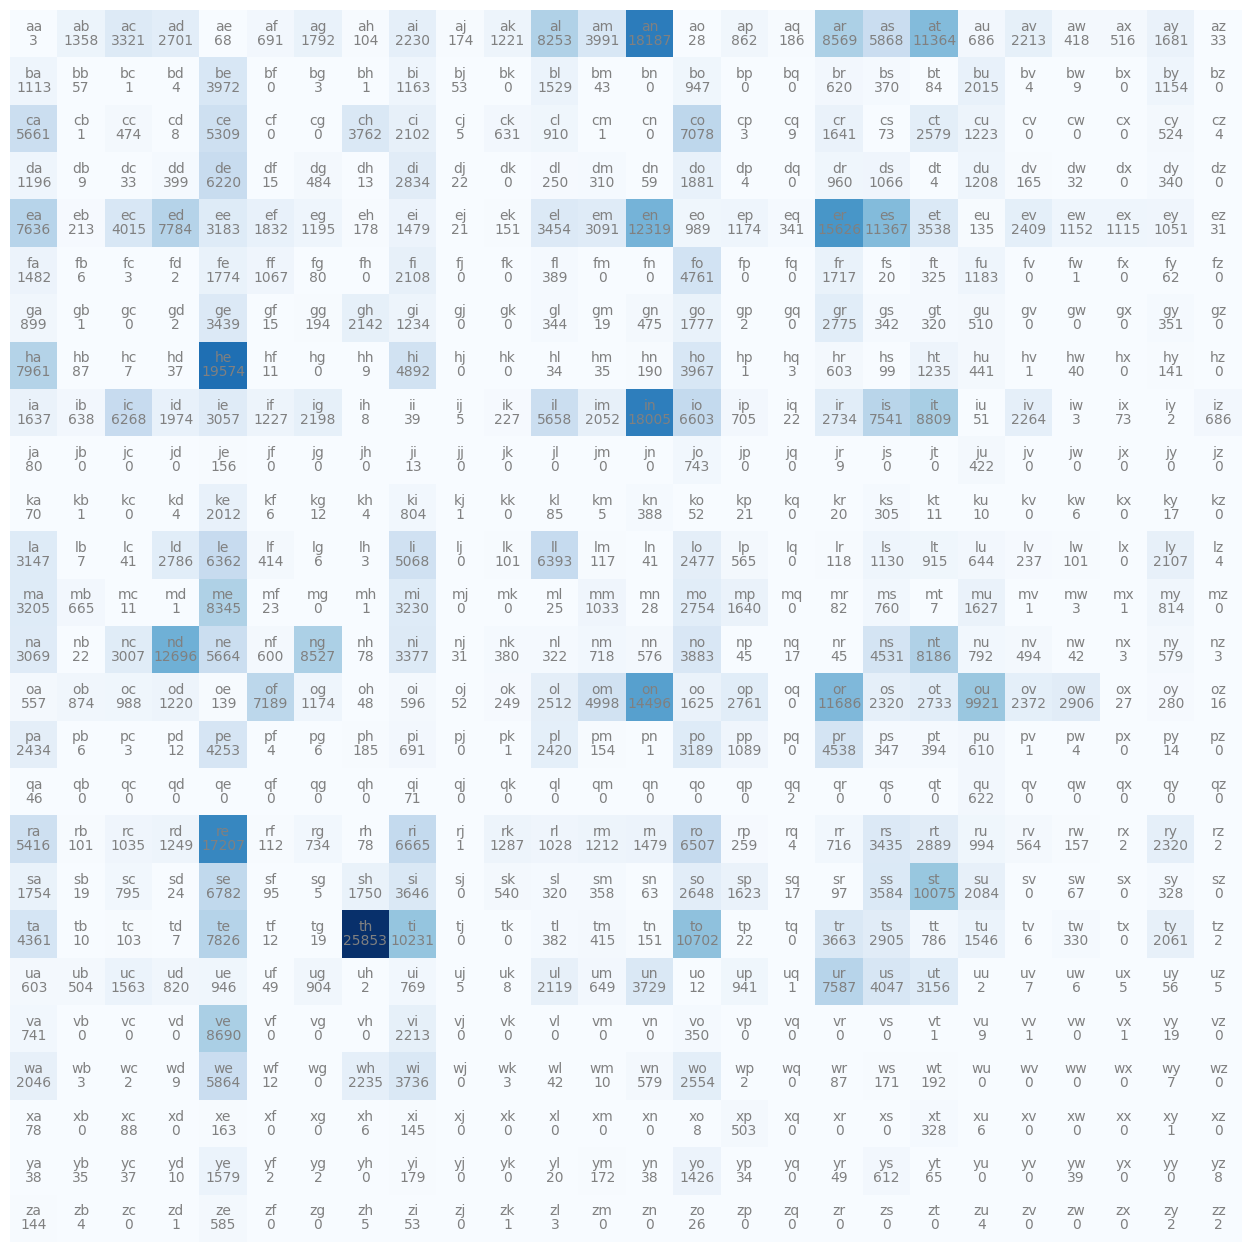

In [24]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(26):
    for j in range(26):
        chstr = itos[i + shift] + itos[j + shift]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Now we plot in a similar way the matrix `model.W`. From far, the two matrices look similar, suggesting that the bigram model is indeed convering towards the frequency matrix.

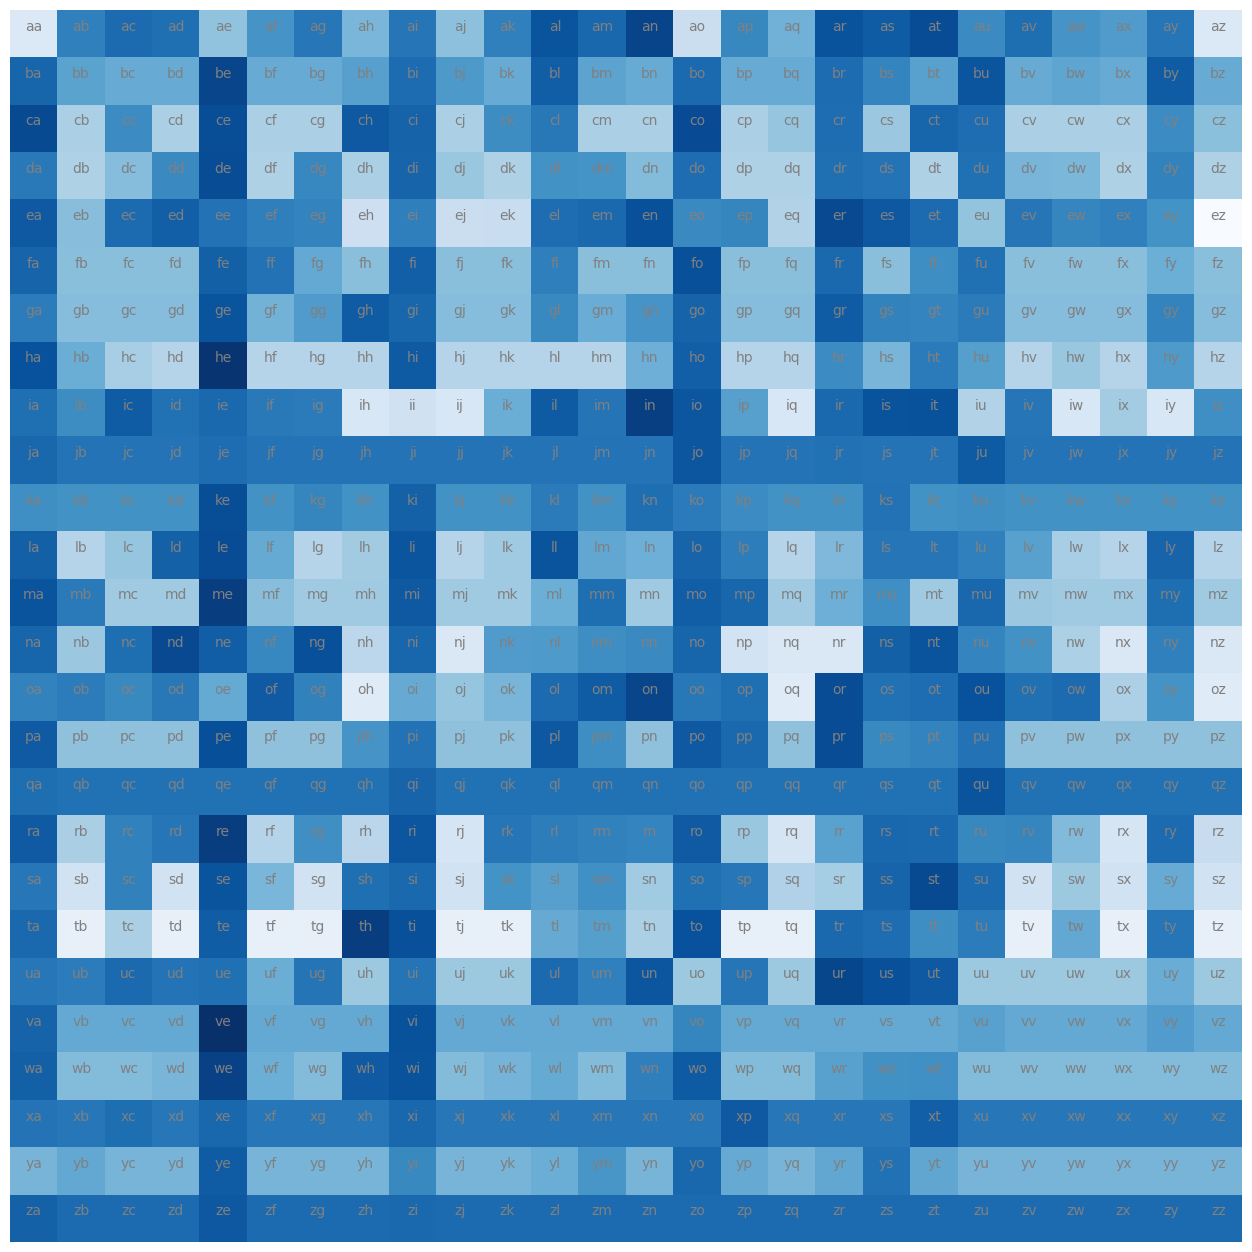

In [25]:
shift = stoi['a']

@torch.no_grad()
def plot_W(model):
    plt.figure(figsize=(16,16))
    W_letters = model.W[shift:shift + 26, shift:shift + 26]
    plt.imshow(W_letters, cmap='Blues')
    for i in range(26):
        for j in range(26):
            chstr = itos[i + shift] + itos[j + shift]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.axis('off');
    
plot_W(model)

Before moving on to more expressive models, let us write the bigram model in a more Pytorch-friendly way.

Also, we add to the loss a regularisation term: `0.1 * (self.net.weights**2).mean()`. By adding this to the loss, we force the weights to be as small as possible, which helps generalisation.

In [27]:
class Bigram(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(vocab_size, vocab_size, bias=False)

    def forward(self, x, y=None):
        logits = self.net(x)
        
        if y is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, y) + 0.1 * (self.net.weight**2).mean()

        return logits, loss    

In [30]:
model = Bigram()
print(sum(p.numel() for p in model.parameters()), ' parameters')

train_no_batch(model, n_iterations = 40000, learning_rate = 1e-3, eval_interval = 2000, eval_iters = 100)
print("\n", generate_bigram(model))

2809  parameters
step 0: train loss 3.9827, val loss 3.9799
step 2000: train loss 3.6479, val loss 3.6471
step 4000: train loss 3.4390, val loss 3.3654
step 6000: train loss 3.2366, val loss 3.2128
step 8000: train loss 3.0559, val loss 3.1464
step 10000: train loss 3.0342, val loss 3.1183
step 12000: train loss 2.9552, val loss 2.8916
step 14000: train loss 2.8832, val loss 2.9585
step 16000: train loss 2.9018, val loss 2.7615
step 18000: train loss 2.9059, val loss 2.9214
step 20000: train loss 2.7702, val loss 2.7653
step 22000: train loss 2.6586, val loss 2.8943
step 24000: train loss 2.7697, val loss 2.8008
step 26000: train loss 2.8122, val loss 2.7040
step 28000: train loss 2.8102, val loss 2.8110
step 30000: train loss 2.9460, val loss 2.8414
step 32000: train loss 2.8156, val loss 2.8255
step 34000: train loss 2.8100, val loss 2.6730
step 36000: train loss 2.7585, val loss 2.7243
step 38000: train loss 2.8638, val loss 2.7410
step 39999: train loss 2.9171, val loss 2.8850

 om

## Part 3: Word-level tokenizer

Instead of working at character level, we will now work at word level. The science of decomposing a text into tokens is a complicated one. Here we use `minbpe`, which implements the Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization.

In [31]:
from minbpe.minbpe import RegexTokenizer

The tokenizer takes a while to run so let's download a tokenizer (obtained using minbpe).

In [32]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.model
!wget https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.vocab

--2024-11-19 21:31:49--  https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2075 (2,0K) [text/plain]
Saving to: ‘tok512.model.1’

tok512.model.1      100%[===================>]   2,03K  --.-KB/s    in 0s      

2024-11-19 21:31:50 (18,1 MB/s) - ‘tok512.model.1’ saved [2075/2075]

--2024-11-19 21:31:50--  https://raw.githubusercontent.com/nathanael-fijalkow/LLM_from_scratch/main/tok512.vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting resp

In [33]:
tokenizer = RegexTokenizer()
tokenizer.load("tok512.model")

As before we encode the entire text dataset and store it into a `torch.Tensor`.

In [34]:
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

data.shape, data[:50]

(torch.Size([586714]),
 tensor([109, 114,  46, 276, 393, 384, 263,  44, 283, 114,  46, 274, 344, 340,
         300,  44, 279, 295, 383, 290, 117, 287, 258, 100, 283, 409,  98, 381,
         280, 262, 296, 301, 319, 279, 276, 270, 379, 461, 104, 264, 367, 100,
         312, 117, 101, 268, 115,  44, 279, 275]))

In [35]:
test = "hello world"
test_encoded = tokenizer.encode(test)
test_encoded, [tokenizer.decode([x]) for x in test_encoded], tokenizer.decode(test_encoded)

([258, 285, 111, 492], ['he', 'll', 'o', ' world'], 'hello world')

The longest tokens in political speeches according to BPE.

In [36]:
token_list = sorted([tokenizer.decode([x]) for x in range(n_token)], 
                    key=len, 
                    reverse=True)
token_list[:20]

[' America',
 'vernment',
 ' Americ',
 ' people',
 ' nation',
 'ongress',
 ' their',
 ' world',
 'ation',
 ' that',
 'meric',
 ' will',
 ' have',
 ' with',
 ' this',
 ' year',
 ' must',
 ' work',
 ' more',
 ' from']

## Part 4: Evaluating and training with batches

Now our models will take as input `block_size` many tokens and produce the next token.

In [38]:
ix = torch.randint(len(data) - block_size, (1,))
sample = data[ix:ix+block_size+1]
sample_list = sample.tolist()
print("Input: ", sample_list[:-1], 
      "\nTarget: ", sample_list[-1])
print("\nHuman version:\nInput: ", tokenizer.decode(sample_list[:-1]), 
      "\nTarget: ", tokenizer.decode([sample_list[-1]]))

Input:  [115, 279, 426, 381, 286, 262, 492, 283, 291, 107, 314, 483, 472, 46, 306, 419] 
Target:  362

Human version:
Input:  s and workers in the world marketplace. we must 
Target:   have


In [39]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size - 1, (batch_size,))
    X = torch.stack([data[i:i+block_size] for i in ix])
    Y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return X, Y

X,Y = get_batch("train")
X.shape, Y.shape

(torch.Size([32, 16]), torch.Size([32, 16]))

We illustrate below how the cross entropy loss is computed along batches (as the mean over the batches). The same works for most functions in Pytorch, which means that writing code for batches is almost as easy as without!

In [40]:
batch_size_test = 3
number_classes_test = 5

logits = torch.randn(batch_size_test, number_classes_test)
target = torch.randint(number_classes_test, (batch_size_test,), dtype=torch.int64)
loss = F.cross_entropy(logits, target)
print("logits: ", logits, "\ntarget: ", target, "\nloss: ", loss.item())

logits:  tensor([[ 2.7571,  0.0786, -0.7813,  1.6285, -0.1642],
        [-0.2555,  0.7809,  1.2446,  0.5726, -0.3185],
        [ 0.8716, -0.6718, -0.3120, -0.1815,  0.6225]]) 
target:  tensor([4, 4, 4]) 
loss:  2.346928119659424


Let us write again the boilerplate code for models, this time with batching.

In [43]:
@torch.no_grad()
def estimate_loss(model, eval_iters = 100):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [42]:
def train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on train and validation sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            losses = estimate_loss(model, eval_iters)
            print(f"step {iter}: train loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

        X,Y = get_batch("train")
        _, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

## Part 5: A Multi Layer Perceptron (MLP) model

We essentially implement the model from the paper "**A Neural Probabilistic Language Model**" by Bengio et al from 2003. It is conveniently added to the repository!

The first component is an `Embedding` layer: this is simply a lookup table, as illustrated below. It maps every token to a vector in fixed dimension. Since the dimension is much smaller than the number of tokens, intuitively the embedding layer will have to map similar tokens to similar vectors.

In [44]:
n_token_test = 3
n_embed_test = 4

embedding = torch.nn.Embedding(n_token_test, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)
print("Result of embedding token number 1:\n", embedding(torch.tensor([1])))

Weights of the embedding:
 Parameter containing:
tensor([[-0.4016, -0.3706,  0.3496,  0.5330],
        [-0.4798, -1.0926, -1.1878, -0.0475],
        [-0.2275,  0.4420,  0.2888,  0.6428]], requires_grad=True)
Result of embedding token number 1:
 tensor([[-0.4798, -1.0926, -1.1878, -0.0475]], grad_fn=<EmbeddingBackward0>)


Let us describe how the model works. 

Recall that a datapoint is a tensor `x` of size `block_size`. Each of the `block_size` token is embedded, yielding a tensor of dimension `n_embed`. The resulting embeddings are concatenated to form a tensor of dimension `block_size * n_embed`, and then fed into a standard feed forward network. This is illustrated below (minus the network), with batches.

In [45]:
batch_size_test = 2
block_size_test = 3
n_token_test = 4
n_embed_test = 5

blank_token_test = n_token_test

idx = torch.randint(high = n_token_test, size = (batch_size_test, block_size_test))
print("Input tokens:\n", idx)
embedding = torch.nn.Embedding(n_token_test + 1, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)

print("*******************\n")

x = embedding(idx)
x.shape, x

Input tokens:
 tensor([[3, 3, 2],
        [3, 0, 0]])
Weights of the embedding:
 Parameter containing:
tensor([[ 1.1716,  0.6339, -0.8440, -1.0350, -0.1783],
        [ 0.3692,  1.1342, -1.7003, -0.8167, -0.5528],
        [ 1.5500, -1.4082, -2.2521, -0.2642, -0.7747],
        [ 1.1685, -0.2519,  0.2267, -0.3279,  0.5115],
        [-0.8359,  0.9596,  1.0358,  1.2401, -1.0417]], requires_grad=True)
*******************



(torch.Size([2, 3, 5]),
 tensor([[[ 1.1685, -0.2519,  0.2267, -0.3279,  0.5115],
          [ 1.1685, -0.2519,  0.2267, -0.3279,  0.5115],
          [ 1.5500, -1.4082, -2.2521, -0.2642, -0.7747]],
 
         [[ 1.1685, -0.2519,  0.2267, -0.3279,  0.5115],
          [ 1.1716,  0.6339, -0.8440, -1.0350, -0.1783],
          [ 1.1716,  0.6339, -0.8440, -1.0350, -0.1783]]],
        grad_fn=<EmbeddingBackward0>))

In [46]:
class MLP(nn.Module):
    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.net = nn.Sequential(
            nn.Linear(block_size * n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_token)
        )

    def forward(self, idx, y=None):
        B, T = idx.shape
        # if training: B = batch_size, otherwise B = 1
        # T = block_size

        x = self.token_embedding_table(idx).view(B, block_size * n_embed)
        # x.shape = (B, block_size * n_embed)
        
        logits = self.net(x) 
        # logits.shape = (B, n_token)
        
        if y is None:
            loss = None
        else:
            # B = batch_size
            # y.shape = (batch_size, block_size)
            logits = logits.view(batch_size, n_token)
            y = y[:,-1].view(batch_size)
            loss = F.cross_entropy(logits, y)

        return logits, loss 

In [47]:
model = MLP(n_embed2 = 4 * n_embed, n_embed = n_embed)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

0.426752  M parameters


In [48]:
def generate_MLP(model, max_new_tokens = 2000):
    idx = torch.ones((1, block_size), dtype=torch.long) * tokenizer.encode("\n")[0]
    for _ in range(max_new_tokens):
        # we crop at block_size
        idx_cond = idx[:, -block_size:]
        # forward pass
        logits, _ = model(idx_cond)
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][block_size:].tolist())

The output is much better than before just because we use tokens, so independently words are more or less fine, but sentences are random.

In [49]:
print(generate_MLP(model, max_new_tokens = 50))

Rromear Anditvernment�mericz� T� f ofore world have�� enard�ion sero�ge� r���mericist�~ thit��X��]�t


In [50]:
train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2716, validation loss 6.2764
step 1000: train loss 4.3778, validation loss 4.5674
step 2000: train loss 4.0589, validation loss 4.2054
step 3000: train loss 3.8281, validation loss 4.0674
step 4000: train loss 3.7198, validation loss 3.9710
step 5000: train loss 3.5520, validation loss 3.9042
step 6000: train loss 3.5584, validation loss 3.8731
step 7000: train loss 3.4792, validation loss 3.8644
step 8000: train loss 3.4085, validation loss 3.8386
step 9000: train loss 3.4031, validation loss 3.7784
step 9999: train loss 3.3250, validation loss 3.7541


In [51]:
print(generate_MLP(model, max_new_tokens = 200))

a haimpacicd guplthem and interderginesments are a state fromrementso are parter andher jobs for the peace of thedviceal budget. the institut states to four, frecommhities ifern the manket that he
mepends. diffore our economic approter stronthe cition would a
conrning the pls of selling and over offins, in economy.
mods no help. i also chisegth, and we must retain our frime to lean bey millions, jobn in admining, the
grime;.

the was


## Part 6: Attention mechanism

### A self-attention head

Attention is a **communication mechanism**. In our case, the tokens communicate information and determine which tokens are relevant for them.

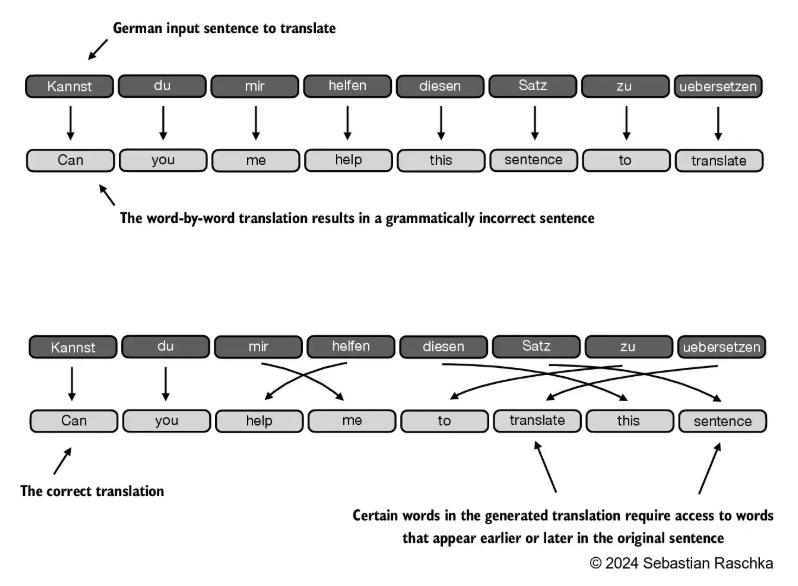

The input of the head is for each token a tensor of dimension `head_input_dim`, forming a tensor `x: (block_size,head_input_dim)`.
The goal is to compute for each token a context tensor, so a tensor `z: (block_size,head_output_dim)`. The context tensor for token `i` will be a weighted average of all input tensors multiplied by their so-called "affinity scores". More precisely, for computing the context tensor for token `i`, we compute the affinity of `i` with each token `j`, and multiply the input of `j` by the affinity of `i` for `j`.

Our strategy for explainining is first by oversimplifying, and then refining our explanations through different versions of the code.

**Version 0**:
Every token emits two vectors of dimension `head_size`:
* a query: *describing the information I am looking for*
* a key: *describing the information I contain*

Both queries and keys are calculated from `x` by applying a linear transformation (one for query, one for key). Importantly, these two linear transformations are learned: their parameters will evolve through training.

To determine the score (affinity) of a token for another one, we use dot-product of query times key. More general formulas could be used.

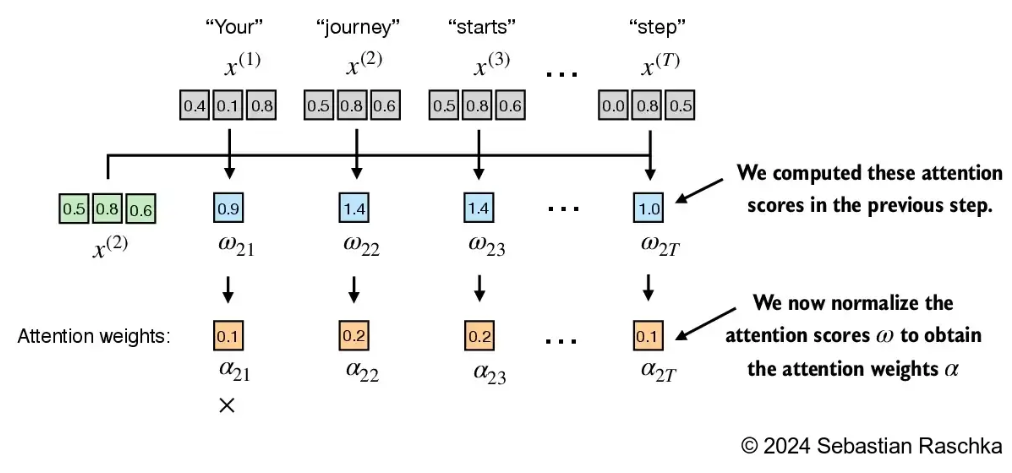

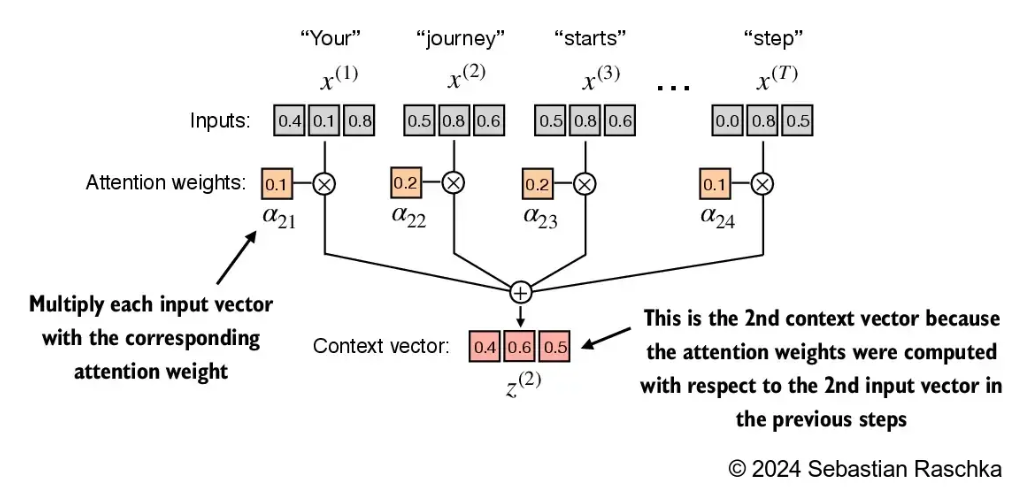

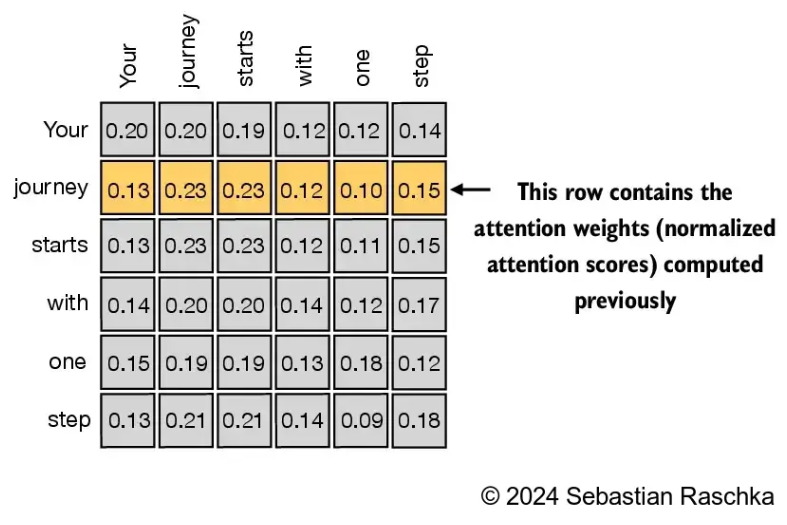

In [53]:
# Code for version 0
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(T, I)

key = nn.Linear(I, H)
query = nn.Linear(I, H)

k = key(x)   # (T, I) @ (I, H) ---> (T, H)
q = query(x) # (T, I) @ (I, H) ---> (T, H)

weights = q @ k.transpose(0, 1) # (T, H) @ (H, T) ---> (T, T)
weights = F.softmax(weights, dim=-1)

out = weights @ x
out.shape

torch.Size([8, 2])

**Version 1**: We add a mask to forbid a token to look at tokens appearing after it.

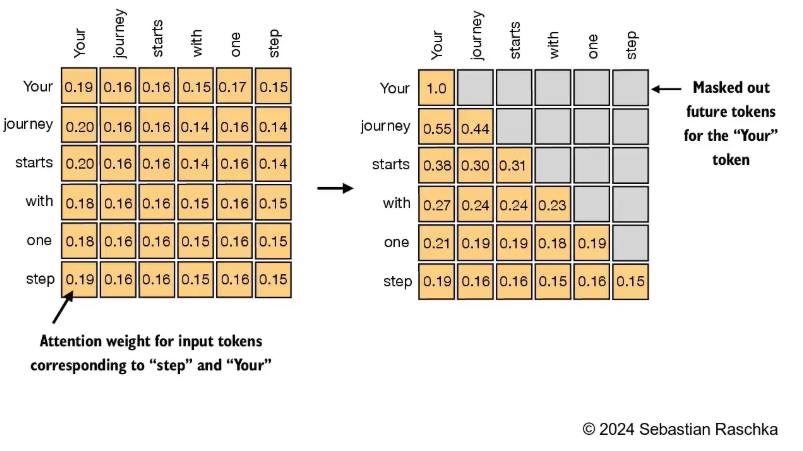

In [54]:
# Code for version 1
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(T, I)

key = nn.Linear(I, H)
query = nn.Linear(I, H)

k = key(x)   # (T, I) @ (I, H) ---> (T, H)
q = query(x) # (T, I) @ (I, H) ---> (T, H)

weights = q @ k.transpose(0, 1) # (T, H) @ (H, T) ---> (T, T)
weights = F.softmax(weights, dim=1)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)
weights

#out = weights @ x

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5217, 0.4783, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3676, 0.3202, 0.3122, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2265, 0.2701, 0.2528, 0.2506, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1774, 0.2330, 0.2126, 0.1928, 0.1842, 0.0000, 0.0000, 0.0000],
        [0.1486, 0.1838, 0.1733, 0.1638, 0.1575, 0.1730, 0.0000, 0.0000],
        [0.1271, 0.1581, 0.1422, 0.1415, 0.1379, 0.1661, 0.1272, 0.0000],
        [0.1604, 0.1137, 0.1123, 0.1200, 0.1369, 0.1298, 0.1160, 0.1110]],
       grad_fn=<SoftmaxBackward0>)

**Version 2**: We add batches.

In [55]:
# Code for version 2
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
k = key(x)   # (B, T, I) @ (I, H) ---> (B, T, H)
q = query(x) # (B, T, I) @ (I, H) ---> (B, T, H)
weights = q @ k.transpose(1, 2) # (B, T, H) @ (B, H, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

out = weights @ x
out.shape

torch.Size([4, 8, 2])

**Version 3**: Every node emits three vectors:
* a query of dimension `head_size`: *describing the information I am looking for*
* a key of dimension `head_size`: *describing the information I contain*
* a value of dimension `head_output_dim`: *the information I reveal*

In [56]:
# Code for version 3
B = 4 # batch_size
T = 8 # block_size
I = 14 # head_input_dim
H = 8 # head_size
O = 16 # head_output_dim

x = torch.randn(B, T, I) # (B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
value = nn.Linear(I, O, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(1, 2) # (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x) 
out = weights @ v # (B, T, T) @ (B, T, O) ---> (B, T, O)
out.shape

torch.Size([4, 8, 16])

**Version 4**: 

There's one important issue: we need to renormalise, otherwise `q @ k` has large variance, and fed into the softmax it becomes almost a Dirac distribution. That's why we do "scaled attention": we additional divide `weights` by `1/sqrt(head_size)`. This makes it so when input `q,k` have unit variance, `weights` will have unit variance too and softmax will stay diffuse and not saturate too much. Illustrations below

In [57]:
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(1, 2)

k.var(), q.var(), weights.var()

(tensor(0.3133, grad_fn=<VarBackward0>),
 tensor(0.3226, grad_fn=<VarBackward0>),
 tensor(2.7276, grad_fn=<VarBackward0>))

Illustration of `softmax` sensitivity to large numbers:

In [58]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5]), dim=-1)

tensor([0.1997, 0.1479, 0.1338, 0.2207, 0.2979])

In [59]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5])*10, dim=-1)

tensor([1.7128e-02, 8.5274e-04, 3.1371e-04, 4.6558e-02, 9.3515e-01])

In [60]:
# Code for version 4
B = 4 # batch_size
T = 8 # block_size
I = 2 # head_input_dim
H = 16 # head_size
O = 6 # head_output_dim

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
value = nn.Linear(I, O, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(1, 2) * H**-0.5

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v
out.shape

torch.Size([4, 8, 6])

**Of course**, each example across batch dimension is processed completely independently, they never "talk" to each other!

### Shall we?

In [61]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_input_dim, head_size, head_output_dim):
        super().__init__()
        self.key = nn.Linear(head_input_dim, head_size, bias=False)
        self.query = nn.Linear(head_input_dim, head_size, bias=False)
        self.value = nn.Linear(head_input_dim, head_output_dim, bias=False)

        self.head_size = head_size

        # Some Pytorch way of defining a matrix without trainable parameters 
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))     

    def forward(self, x):
        B, T, C = x.shape
        # if training: B = batch_size, else B = 1
        # T = block_size
        # I = head_input_dim
        # H = head_size
        # O = head_output_dim
        
        k = self.key(x)   # (B, T, H)
        q = self.query(x) # (B, T, H)
        weights = q @ k.transpose(1,2) * self.head_size**-0.5 # (B, T, H) @ (B, H, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = F.softmax(weights, dim=-1) # (B, T, T)
        v = self.value(x) # (B, T, O)
        out = weights @ v # (B, T, T) @ (B, T, O) -> (B, T, O)
        return out

**Positional encoding**: There is no notion of space, the attention mechanism acts over a **set** of vectors. This is why we need to positionally encode tokens. Two solutions:
* Learning an embedding of positions
* Using a fixed embedding

Here we use the first solution but illustrate the second one below.

Suppose that the input representation $X \in \mathbb{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. 
The positional encoding outputs $X + P$ using a positional embedding matrix $P$ of the same shape, whose element on the $i$-th row and the $2j$-th or the $2j+1$-th column is
$$P(i,2j) = \text{sin}\left( \frac{i}{10000^{2j / d}} \right)$$
$$P(i,2j+1) = \text{cos}\left( \frac{i}{10000^{2j / d}} \right)$$

Credit for the code and picture: Jonathan Kernes, https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3

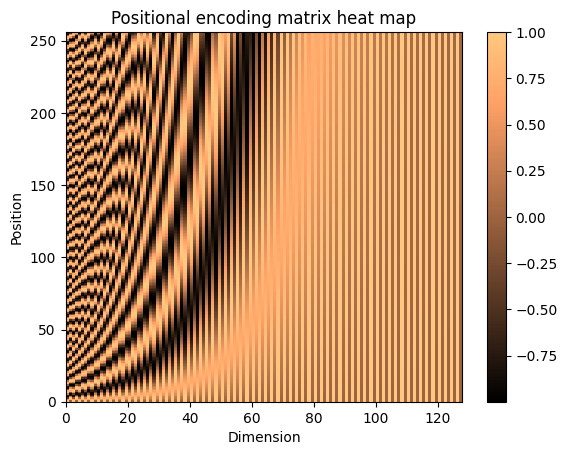

In [62]:
import numpy as np

def positional_encoding(max_position, model_dim, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(model_dim)//2)/model_dim)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc
    
model_dim = 128
max_pos = 256
mat = positional_encoding(max_pos, model_dim)
plt.pcolormesh(mat, cmap='copper')
plt.xlabel('Dimension')
plt.xlim((0, model_dim))
plt.ylabel('Position')
plt.title("Positional encoding matrix heat map")
plt.colorbar()
plt.show()

This model is just an illustration of what can be done with a single head plus positional encoding.

In [63]:
class SingleHeadPositional(nn.Module):
    
    def __init__(self, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.self_attention_head = Head(head_input_dim = n_embed, 
                                        head_size = head_size, 
                                        head_output_dim = head_output_dim)
        self.last_head = nn.Linear(head_output_dim, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # T = block_size
        
        # I = head_input_dim = n_embed
        # H = head_size
        # O = head_output_dim

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_head(x) # (B, T, H)
        logits = self.last_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [64]:
def generate(model, max_new_tokens = 2000):
    idx = torch.ones((1, block_size), dtype=torch.long) * tokenizer.encode("\n")[0]
    for _ in range(max_new_tokens):
        # we crop at block_size
        idx_cond = idx[:, -block_size:]
        # forward pass
        logits, _ = model(idx_cond)
        # use the logits for the full context
        logits = logits[:,-1,:]
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][block_size:].tolist())

In [65]:
model = SingleHeadPositional(head_size = 16, head_output_dim = n_embed)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

0.073216  M parameters


In [66]:
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2555, validation loss 6.2559
step 1000: train loss 3.9857, validation loss 4.1012
step 2000: train loss 3.7806, validation loss 3.8982
step 3000: train loss 3.6942, validation loss 3.8400
step 4000: train loss 3.6507, validation loss 3.8045
step 5000: train loss 3.6112, validation loss 3.7800
step 6000: train loss 3.5942, validation loss 3.7504
step 7000: train loss 3.5537, validation loss 3.7291
step 8000: train loss 3.5376, validation loss 3.7219
step 9000: train loss 3.5288, validation loss 3.7019
step 10000: train loss 3.5228, validation loss 3.6904
step 11000: train loss 3.5123, validation loss 3.6890
step 12000: train loss 3.4910, validation loss 3.6774
step 13000: train loss 3.4916, validation loss 3.6787
step 14000: train loss 3.4848, validation loss 3.6694
step 15000: train loss 3.4741, validation loss 3.6794
step 16000: train loss 3.4653, validation loss 3.6623
step 17000: train loss 3.4667, validation loss 3.6631
step 18000: train loss 3.4509, validation

In [67]:
print(generate(model, max_new_tokens = 200))

bary rem, every. seersone: 19810s
not opporting so--asing, congress,
ps of disish alsonip, a american and out by the ier bother stay and in trons. the misrate into labic partsan 1982 porgicit le thre wone, we lothhments; sect and so it congress--those croritive teste that on these americans will not acho was in there ir congress. a pense of plointer congress benly, we here work and $5.

ative one
now its is social are trubant


### From single head to multi headed attention

In [68]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_input_dim = n_embed, 
                                         head_size = head_size, 
                                         head_output_dim = head_output_dim) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_output_dim, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

We enrich the previous model with parallel heads, called multi head.

In [69]:
class MultiHeadPositional(nn.Module):
    
    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                      head_size = head_size,
                                                      head_output_dim = head_output_dim) 
        self.last_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = block_size
        # I = head_input_dim 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_heads(x) # (B, T, n_embed)
        logits = self.last_head(x) # (B, T, n_token)
        
        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [70]:
model = MultiHeadPositional(n_head = 6, 
                            head_size = 16,
                           head_output_dim = 16)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)
print(generate(model, max_new_tokens = 200))

0.091712  M parameters
step 0: train loss 6.2569, validation loss 6.2578
step 1000: train loss 3.9087, validation loss 4.0495
step 2000: train loss 3.6221, validation loss 3.7742
step 3000: train loss 3.4532, validation loss 3.6507
step 4000: train loss 3.3387, validation loss 3.5701
step 5000: train loss 3.2812, validation loss 3.4832
step 6000: train loss 3.2305, validation loss 3.4763
step 7000: train loss 3.1764, validation loss 3.4418
step 8000: train loss 3.1408, validation loss 3.4194
step 9000: train loss 3.1336, validation loss 3.3848
step 10000: train loss 3.0967, validation loss 3.3881
step 11000: train loss 3.0964, validation loss 3.3419
step 12000: train loss 3.0691, validation loss 3.3293
step 13000: train loss 3.0537, validation loss 3.3474
step 14000: train loss 3.0553, validation loss 3.2987
step 15000: train loss 3.0317, validation loss 3.3022
step 16000: train loss 3.0208, validation loss 3.2997
step 17000: train loss 3.0026, validation loss 3.2849
step 18000: train 

## Some deep learning magic to make training easier

### Normalization layers

In [71]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [72]:
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

We compute the mean and standard deviation of one (the first) feature across all batch inputs:

In [73]:
x[:,0].mean(), x[:,0].std()
# NOT normalised

(tensor(0.0146), tensor(0.9626))

Now, the mean and standard deviation of the features for a single input from the batch:

In [74]:
x[0,:].mean(), x[0,:].std()
# normalised

(tensor(-2.3842e-09), tensor(1.0000))

### Sequential blocks

In [75]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_embed),
        )

    def forward(self, x):
        return self.net(x)

In [76]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_head, head_size, head_output_dim, n_embed2):
        super().__init__()
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                       head_size = head_size,
                                                       head_output_dim = head_output_dim)
        self.ffwd = FeedFoward(n_embed2 = n_embed2, n_embed = n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # here are skip connections, also called residual connections
        # they help training deep neural networks by adding a pathway to the input
        x = x + self.self_attention_heads(x)

        # normalization layer; recent implementations put them before self attention heads!
        x = self.ln1(x)
        
        # and again skip connections:
        x = x + self.ffwd(x)

        # and again normalization layer
        x = self.ln2(x)

        return x

This is the full model, almost as in the **Attention is all you need** paper (see below for differences).

In [77]:
class LanguageModel(nn.Module):

    def __init__(self, n_head, head_size, head_output_dim, n_embed2, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_head, head_size, head_output_dim, n_embed2) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # I = head_input_dim = head_output_dim = n_embed

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)
        x = self.blocks(x) # (B, T, I)
        x = self.ln_f(x) # (B, T, I)
        logits = self.lm_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            B, T, _ = logits.shape
            logits = logits.view(B*T, n_token)
            y = y.view(B*T)
            loss = F.cross_entropy(logits, y)

        return logits, loss

In [78]:
model = LanguageModel(n_head = 6, 
                      head_size = 16,
                      head_output_dim = 16,
                      n_embed2 = 4 * n_embed,
                      n_layer = 4)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

0.299136  M parameters
step 0: train loss 6.4117, validation loss 6.4121
step 1000: train loss 3.5639, validation loss 3.7382
step 2000: train loss 3.2189, validation loss 3.4560
step 3000: train loss 3.0701, validation loss 3.3179
step 4000: train loss 3.0061, validation loss 3.2707
step 5000: train loss 2.9014, validation loss 3.2121
step 6000: train loss 2.8627, validation loss 3.1617
step 7000: train loss 2.8446, validation loss 3.1498
step 8000: train loss 2.7879, validation loss 3.1198
step 9000: train loss 2.7738, validation loss 3.1077
step 10000: train loss 2.7353, validation loss 3.1034
step 11000: train loss 2.7313, validation loss 3.0708
step 12000: train loss 2.6987, validation loss 3.0517
step 13000: train loss 2.7093, validation loss 3.0609
step 14000: train loss 2.6777, validation loss 3.0402
step 15000: train loss 2.6517, validation loss 3.0164
step 16000: train loss 2.6455, validation loss 3.0459
step 17000: train loss 2.6455, validation loss 3.0183
step 18000: train 

In [79]:
print(generate(model, max_new_tokens = 500))

one advances distvel that instruly full treless, the vital resources juming to how.

that is a now brontiers and buy detail thes of the less between sece.

we incisionwargeted our idepecific, elections:

"i propose to apport the continuest the polled--and we do not igrongly in presentremost and
aling toas taxes, and we can achievag. if they're termined an situte and the murderal reconcebbither, or ask ports to gamous future should have. she opportunities, as locky to make the stithxing spending in fure that requested. we come on the families, some move together
which over farmas. as higher, the succeeda,
human communities, which we will continue to work, or not if young
areag from field stressing by lower good between egun use of classroom,"your u.s. we worked be goonding the balance of the course of 21sives. but i thank you to be the on
the united could have move from claighefforger libya. the budget proposal levels of course because an need to verifications believe intach of the west

Machine translation requires an encoder-decoder architecture:
* the encoder encodes the input, using the exact same code as above, except that self attention is not masked (all tokens communicate with each other). To get an "encoder" attention block we just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* the decoder is still auto-regressive, meaning it's conditioned on what's already been generated, but also on the result of the encoder. More specifically, the keys and values in each attention layer are coming from the encoder itself. The term "self-attention" means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).

ChatGPT (or prompting) requires a fine-tuning phase (we covered only pre-training) where the network aligns with prompts and expected answers. It's based on reinforcement learning and a reward model for correct answers to prompts.

The full Transformer architecture (credits: original paper, Attention is all you need)

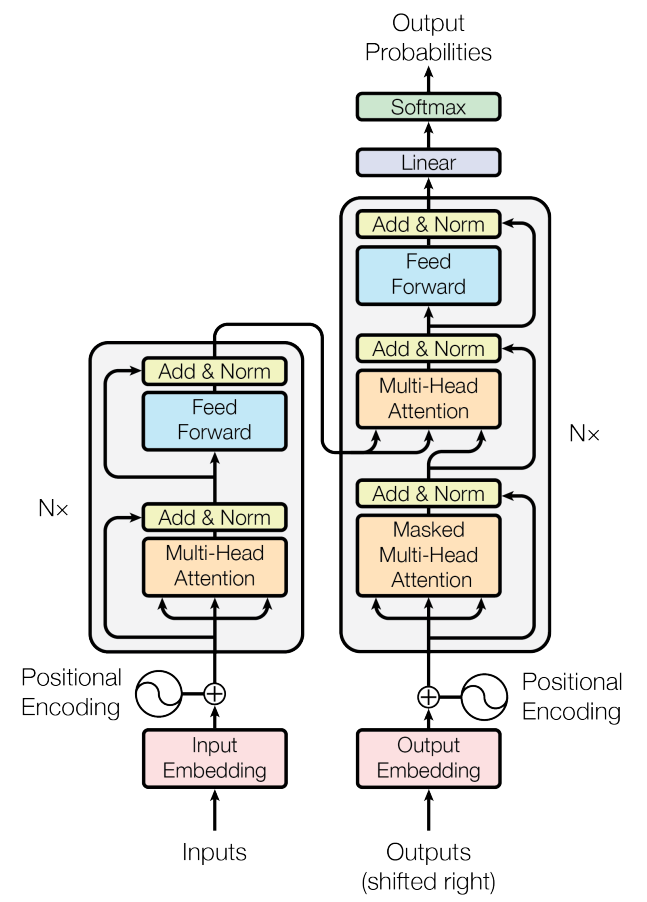